In [64]:
"""
    Package Installation
"""
__author__ = "SakibApon"
__email__ = "sakibapon7@gmail.com"

import os
import pywt
import numpy as np
import pandas as pd
from numpy import argmax
import matplotlib.pyplot as plt
from pandas import DataFrame

import graphviz
import xgboost as xgb
from xgboost import plot_tree
from scipy import signal

import sklearn
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Without Recursive Continuous Wavelet Transformation 

In [2]:
data = pd.read_csv('../input/bledataset/BLE_rssi_after_FFT_Filter_Grid_1.5m_1.25m.csv')

data = data.drop(['date'],axis=1)

#Performance List
l = []

X = data.iloc[:,1:]
y = data.iloc[:,0]

#Encoder
le = LabelEncoder()
y = le.fit_transform(y)

trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Recursive Continuous Wavelet Transformation 

In [7]:
data = pd.read_csv('../input/bledataset/BLE_rssi_after_FFT_Filter_Grid_1.5m_1.25m.csv')

data = data.drop(['date'],axis=1)

#Performance List
l = []

"""Instructions:
In following we will apply wavelet transformationm. The transformation is a two dimential matix. I took first column as a transformed data.
That provides better result. I then do it for multi times. That is, every time, I took first column of the transformed data,
And then I re-apply wavelet on the extracted column data. How many times do we want to perform that wavelet transform, that I controlled by t."""

t = 3
widths = np.arange(1, len(data)+1)

for k in range(1,t):
    for i in range(1,6):
        cwtmatr = signal.cwt(data.iloc[:,i], signal.ricker, widths)
        (cA, cD) = pywt.dwt([1,2,3,4,5,6], 'db1')

        cwtmatr=cwtmatr.astype(int)
        data.iloc[:,i]=cwtmatr[:,0]

X = data.iloc[:,1:]
y = data.iloc[:,0]

#Encoder
le = LabelEncoder()
y = le.fit_transform(y)

trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.2, random_state = 0)

## XG Boost

In [36]:
xgb_classifier = xgb.XGBClassifier(max_depth = 2)
xgb_classifier.fit(trainX, trainY)

predY_XGB = xgb_classifier.predict(testX)
accuracy = round(accuracy_score(testY, predY_XGB),4) * 100 
print("XG Boost without Optimization: ", accuracy)

XG Boost without Optimization:  97.1


### Best Fitted Depth

In [10]:
XGBestimator = []
for i in range(1, 20):
    xgb_classifier = xgb.XGBClassifier(max_depth = i, learning_rate = 0.2, n_estimators = 300, objective='multi:softprob', booster='gbtree')
    xgb_classifier.fit(trainX, trainY)
    predY_XGB = xgb_classifier.predict(testX)
    accuracy = round(accuracy_score(testY, predY_XGB),4)*100 
    print(i, accuracy)
    XGBestimator.append(accuracy)
(XGBestimator.index(max(XGBestimator)))+1

1 96.71
2 97.26
3 97.1
4 97.34
5 97.42
6 97.34
7 97.34
8 97.42
9 97.42
10 97.42
11 97.42
12 97.42
13 97.42
14 97.42
15 97.42
16 97.42
17 97.42
18 97.42
19 97.42


5

### Best Fitted Min Child Weight 

In [41]:
XGBestimatorChild = []
for i in range(1, 10):
    xgb_classifier = xgb.XGBClassifier(max_depth = 5, learning_rate = 0.2, n_estimators = 300, objective='multi:softprob', booster='gbtree', min_child_weight  =  i)
    xgb_classifier.fit(trainX, trainY)
    predY_XGB = xgb_classifier.predict(testX)
    accuracy = round(accuracy_score(testY, predY_XGB),4)*100 
    print(i, accuracy)
    XGBestimatorChild.append(accuracy)
(XGBestimatorChild.index(max(XGBestimatorChild)))+1

1 97.42
2 97.1
3 97.34
4 97.49
5 97.49
6 97.57000000000001
7 97.42
8 97.49
9 97.34


6

<Figure size 432x288 with 0 Axes>

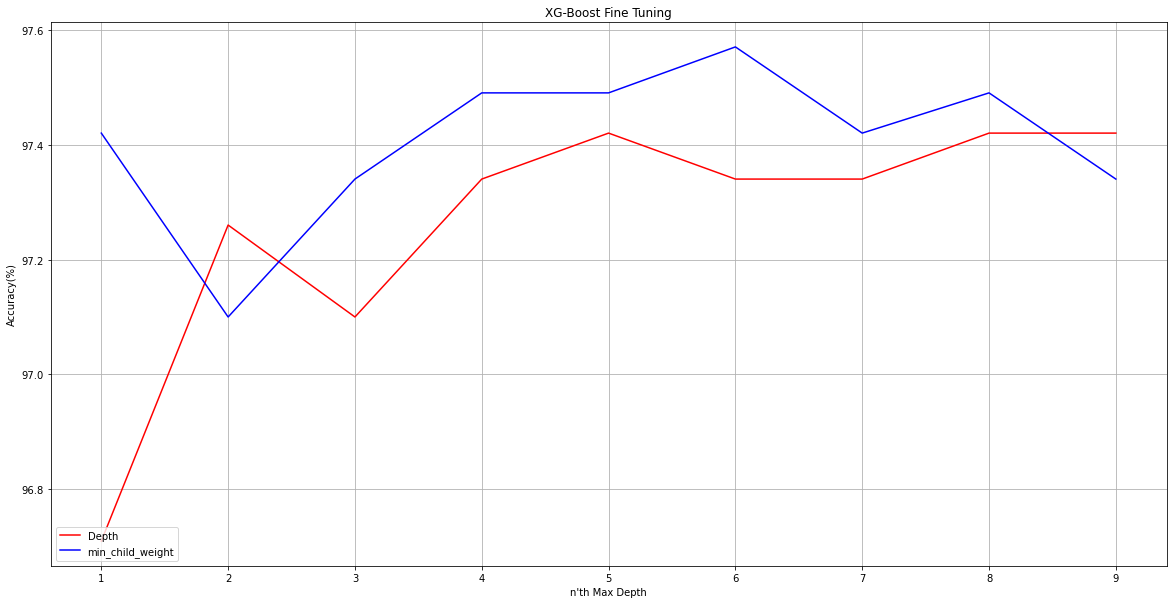

In [57]:
depth = XGBestimator[:9]
child = XGBestimatorChild
x=[1, 2, 3, 4, 5, 6, 7, 8, 9]

fig = plt.figure()

plt.figure(figsize=(20,10))
plt.plot(x[0:9], depth[0:9],'r')
plt.plot(x[0:9], child[0:9],'b')
plt.title('XG-Boost Fine Tuning')
plt.ylabel('Accuracy(%)')
plt.xlabel("n'th Max Depth")
plt.legend(['Depth', 'min_child_weight'], loc='lower left')
plt.grid()

In [61]:
xgb_classifier = xgb.XGBClassifier(max_depth = 5, learning_rate = 0.2, n_estimators = 300, objective='multi:softprob', booster='gbtree',  min_child_weight  =  6)
xgb_classifier.fit(trainX, trainY)

"""plot_tree(xgb_classifier,  num_trees=4)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')
plt.show()"""

predY_XGB = xgb_classifier.predict(testX)

modelName = "XGB"
accuracy = round(accuracy_score(testY, predY_XGB),4)*100 
precision = round(precision_score(testY, predY_XGB, average='micro'),4)*100 
recall = round(recall_score(testY, predY_XGB, average='micro'),4)*100 
f1 = round(f1_score(testY, predY_XGB, average='micro'),4)*100

l.append([modelName, accuracy, precision, recall, f1])

#my_dict['Mean Absolute Error'] = metrics.mean_absolute_error(testY, predY_XGB)
#my_dict['Mean Squared Error'] = metrics.mean_squared_error(testY, predY_XGB)
#my_dict['Root Mean Squared Error'] = np.sqrt(metrics.mean_squared_error(testY, predY_XGB))

### Random Forest

In [5]:
"""regressor = sklearn.ensemble.RandomForestRegressor(n_estimators = 220, random_state = 2)
regressor.fit(trainX,trainY)

predY_RF = regressor.predict(testX)

yy=[]
for i in range(0,len(predY_RF)):
    yy.append(int(predY_RF[i]))
predY_RF = yy

modelName = "Random Forest"
accuracy = round(accuracy_score(testY, predY_RF),4)*100 
precision = round(precision_score(testY, predY_RF, average='micro'),4)*100 
recall = round(recall_score(testY, predY_RF, average='micro'),4)*100 
f1 = round(f1_score(testY, predY_RF, average='micro'),4)*100
l.append([modelName, accuracy, precision, recall, f1])"""

### GaussianNB

In [62]:
gnb = GaussianNB()
gnb.fit(trainX, trainY)
predY=gnb.predict(testX)

modelName = "GaussianNB"
accuracy = round(accuracy_score(testY, predY),4)*100 
precision = round(precision_score(testY, predY, average='micro'),4)*100 
recall = round(recall_score(testY, predY, average='micro'),4)*100 
f1 = round(f1_score(testY, predY, average='micro'),4)*100
l.append([modelName, accuracy, precision, recall, f1])

In [63]:
df = DataFrame (l, columns=[ 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
df

,Model,Accuracy,Precision,Recall,F1-Score
0,XGB,97.57,97.57,97.57,97.57
1,GaussianNB,59.98,59.98,59.98,59.98


# 2nd Part

In [65]:
data = pd.read_csv('../input/bledataset/BLE_rssi_after_FFT_Filter_Grid_1.5m_2.5m.csv')

data=data.drop(['date'],axis=1)
t=2
widths = np.arange(1, len(data)+1)

In [66]:
#"""Activate thi section when you want to apply wavelet transform
for k in range(1,t):
    for i in range(1,6):
        cwtmatr = signal.cwt(data.iloc[:,i], signal.ricker, widths)
        cwtmatr=cwtmatr.astype(int)
        data.iloc[:,i]=cwtmatr[:,0]
#"""

In [67]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
trainX, testX, trainY, testY = train_test_split(X, y, test_size= 0.1, random_state=42)
orgtestY = testY

#Learning parameter initialization
windowX = 5
windowY = 5
n_classes = len(data.iloc[:,0].unique())
kernelCNN_Dim=(3,3)
epochs = 200
batch_size = 128

## SVC

### SVC Poly

In [68]:
svcPoly = SVC(kernel='poly', degree=3)
svcPoly.fit(trainX, trainY)
predPolyX = svcPoly.predict(testX)

modelName = "SVC Poly"
accuracy = round(accuracy_score(testY, predPolyX),4)*100 
precision = round(precision_score(testY, predPolyX, average='micro'),4)*100 
recall = round(recall_score(testY, predPolyX, average='micro'),4)*100 
f1 = round(f1_score(testY, predPolyX, average='micro'),4)*100
l.append([modelName, accuracy, precision, recall, f1])

### SVC Sigmoid

In [69]:
svcSigmoid = SVC(kernel='sigmoid')
svcSigmoid.fit(trainX, trainY)
predSigmoidX = svcSigmoid.predict(testX)

modelName = "SVC Sigmoid"
accuracy = round(accuracy_score(testY, predSigmoidX),4)*100 
precision = round(precision_score(testY, predSigmoidX, average='micro'),4)*100 
recall = round(recall_score(testY, predSigmoidX, average='micro'),4)*100 
f1 = round(f1_score(testY, predSigmoidX, average='micro'),4)*100
l.append([modelName, accuracy, precision, recall, f1])

### One-hot encoding

In [70]:
targetY = trainY
targetY=targetY.append(testY)
Y_target=pd.get_dummies(targetY)

totalTrainingRow = int(len(data) * 0.9)

Y_train=Y_target.iloc[0:totalTrainingRow]
Y_test=Y_target.iloc[totalTrainingRow:]

### DNN 

In [71]:
model = Sequential()
model.add(Dense(50, input_shape=(trainX.shape[1],), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.summary()

metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes = Y_train.shape[1]), 
               tf.keras.metrics.AUC(), tfa.metrics.CohenKappa(num_classes = Y_train.shape[1])]
               
#callbacks
checkpoint = ModelCheckpoint('DNN.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience = 10, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.01)
callbacks = [earlystop, checkpoint, learning_rate_reduction]

model.compile(loss='categorical_crossentropy', metrics = metrics, optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                300       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 55)                5555      
Total params: 10,955
Trainable params: 10,955
Non-trainable params: 0
_________________________________________________________________


2022-07-05 19:30:08.853716: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [72]:
model.fit(trainX, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(testX, Y_test), callbacks = callbacks)

2022-07-05 19:30:13.536979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
45/45 [==============================] - 4s 27ms/step - loss: 169.7381 - accuracy: 0.0566 - precision: 0.0504 - recall: 0.0472 - f1_score: 0.0640 - auc: 0.5402 - cohen_kappa: 0.0377 - val_loss: 53.9044 - val_accuracy: 0.1033 - val_precision: 0.0879 - val_recall: 0.0829 - val_f1_score: 0.0949 - val_auc: 0.5777 - val_cohen_kappa: 0.0930
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 29.7308 - accuracy: 0.1484 - precision: 0.1474 - recall: 0.1262 - f1_score: 0.1572 - auc: 0.6069 - cohen_kappa: 0.1288 - val_loss: 18.9185 - val_accuracy: 0.1862 - val_precision: 0.2017 - val_recall: 0.1815 - val_f1_score: 0.1553 - val_auc: 0.6285 - val_cohen_kappa: 0.1642
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 13.2789 - accuracy: 0.1992 - precision: 0.2595 - recall: 0.1722 - f1_score: 0.2040 - auc: 0.6447 - cohen_kappa: 0.1796 - val_loss: 8.3472 - val_accuracy: 0.2363 - val_precision: 0.3098 - val_recall: 0.2332 - val_f1_score: 0.1990 - 

In [76]:
#modelPred = argmax(model.predict(testX),axis=1)
modelName = "DNN"
accuracy =  0.3850  * 100 
precision = 0.8919 * 100 
recall =  0.3099 * 100 
f1 =  0.3215  * 100 
l.append([modelName, accuracy, precision, recall, f1])

### CNN

In [73]:
x_test = testX
y_test = Y_test

# implement code to predict using CNN

#convert 1D pattern to 1Dx1D matrix
def OnedToTwoDClone(pattern):
    Array2D = [pattern] + [pattern for i in pattern]
    return np.vstack(tuple(Array2D))

#convert 1D pattern to 1Dxrows matrix
def OneToTwoDClone(pattern, rows):
    return np.reshape(np.tile(pattern, rows), len(pattern)*rows)

#convert whole dataset to size of columns x rows and flatten them 
#then generate the dataset
trainX = np.tile(trainX, np.shape(trainX)[1])
testX = np.tile(testX, np.shape(testX)[1])

print(np.shape(trainX))
print(np.shape(testX))

trainX = trainX.astype('float32')
testX = testX.astype('float32')
maxVal = np.max(np.max(data.iloc[:,1:-1]))

trainX /= maxVal
testX /= maxVal
# Change the data dimensionality according to your data here
trainX = trainX.reshape(trainX.shape[0], windowX, windowY, 1)
testX = testX.reshape(testX.shape[0], windowX, windowY, 1)

(5743, 25)
(639, 25)


In [74]:
modelCNN = Sequential()
modelCNN.add(Conv2D(150, kernel_size=kernelCNN_Dim, strides=(1,1), padding='valid', activation='relu', input_shape=(windowX, windowY,1)))
modelCNN.add(Conv2D(200, kernel_size=kernelCNN_Dim, strides=(1,1), padding='valid', activation='relu'))
modelCNN.add(Flatten())
modelCNN.add(Dense(100, activation='relu'))
modelCNN.add(Dense(150, activation='relu'))
modelCNN.add(Dense(n_classes, activation='softmax'))#Number of classes 55
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes = n_classes), 
               tf.keras.metrics.AUC(), tfa.metrics.CohenKappa(num_classes = n_classes)]

#callbacks
checkpoint = ModelCheckpoint('CNN.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience = 10, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.01)
callbacks = [earlystop, checkpoint, learning_rate_reduction]

modelCNN.compile(loss='categorical_crossentropy', metrics = metrics, optimizer='adam')
modelCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 3, 150)         1500      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 200)         270200    
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_4 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_5 (Dense)              (None, 55)                8305      
Total params: 315,255
Trainable params: 315,255
Non-trainable params: 0
________________________________________________

In [75]:
modelCNN.fit(trainX, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(testX, Y_test), callbacks = callbacks)

Epoch 1/200
45/45 [==============================] - 4s 40ms/step - loss: 3.7033 - accuracy: 0.0691 - precision_1: 0.6667 - recall_1: 6.9650e-04 - f1_score: 0.0234 - auc_1: 0.7016 - cohen_kappa: 0.0230 - val_loss: 3.3454 - val_accuracy: 0.1236 - val_precision_1: 1.0000 - val_recall_1: 0.0125 - val_f1_score: 0.0466 - val_auc_1: 0.7942 - val_cohen_kappa: 0.0782
Epoch 2/200
45/45 [==============================] - 1s 19ms/step - loss: 3.1391 - accuracy: 0.1416 - precision_1: 0.7005 - recall_1: 0.0265 - f1_score: 0.1017 - auc_1: 0.8293 - cohen_kappa: 0.1050 - val_loss: 2.8345 - val_accuracy: 0.2191 - val_precision_1: 0.8095 - val_recall_1: 0.0532 - val_f1_score: 0.1369 - val_auc_1: 0.8717 - val_cohen_kappa: 0.1779
Epoch 3/200
45/45 [==============================] - 1s 20ms/step - loss: 2.8098 - accuracy: 0.2042 - precision_1: 0.7423 - recall_1: 0.0672 - f1_score: 0.1822 - auc_1: 0.8694 - cohen_kappa: 0.1762 - val_loss: 2.5958 - val_accuracy: 0.2676 - val_precision_1: 0.7980 - val_recall_1

In [ ]:
modelCNNPred = argmax(modelCNN.predict(testX),axis=1)

In [77]:
modelName = "CNN"
accuracy = 0.5102  * 100 
precision = 0.8913 * 100 
recall = 0.4491 * 100 
f1 = 0.4534 * 100 
l.append([modelName, accuracy, precision, recall, f1])

In [110]:
df = DataFrame (l, columns=[ 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
df = df.sort_values(by='Accuracy', ascending= True)
df

,Model,Accuracy,Precision,Recall,F1-Score
3,SVC Sigmoid,7.82,7.82,7.82,7.82
2,SVC Poly,11.11,11.11,11.11,11.11
4,DNN,38.50,89.19,30.99,32.15
5,CNN,51.02,89.13,44.91,45.34
1,GaussianNB,59.98,59.98,59.98,59.98
0,XGB,97.57,97.57,97.57,97.57


In [145]:
"""ax = df.plot(x='Model',  kind='bar',title='Performance Evaluation',legend=True, figsize=(15, 10))
plt.grid()
ax.set_xlabel("x label")
ax.set_ylabel("Algorithms")"""

'ax = df.plot(x=\'Model\',  kind=\'bar\',title=\'Performance Evaluation\',legend=True, figsize=(15, 10))\nplt.grid()\nax.set_xlabel("x label")\nax.set_ylabel("Algorithms")'

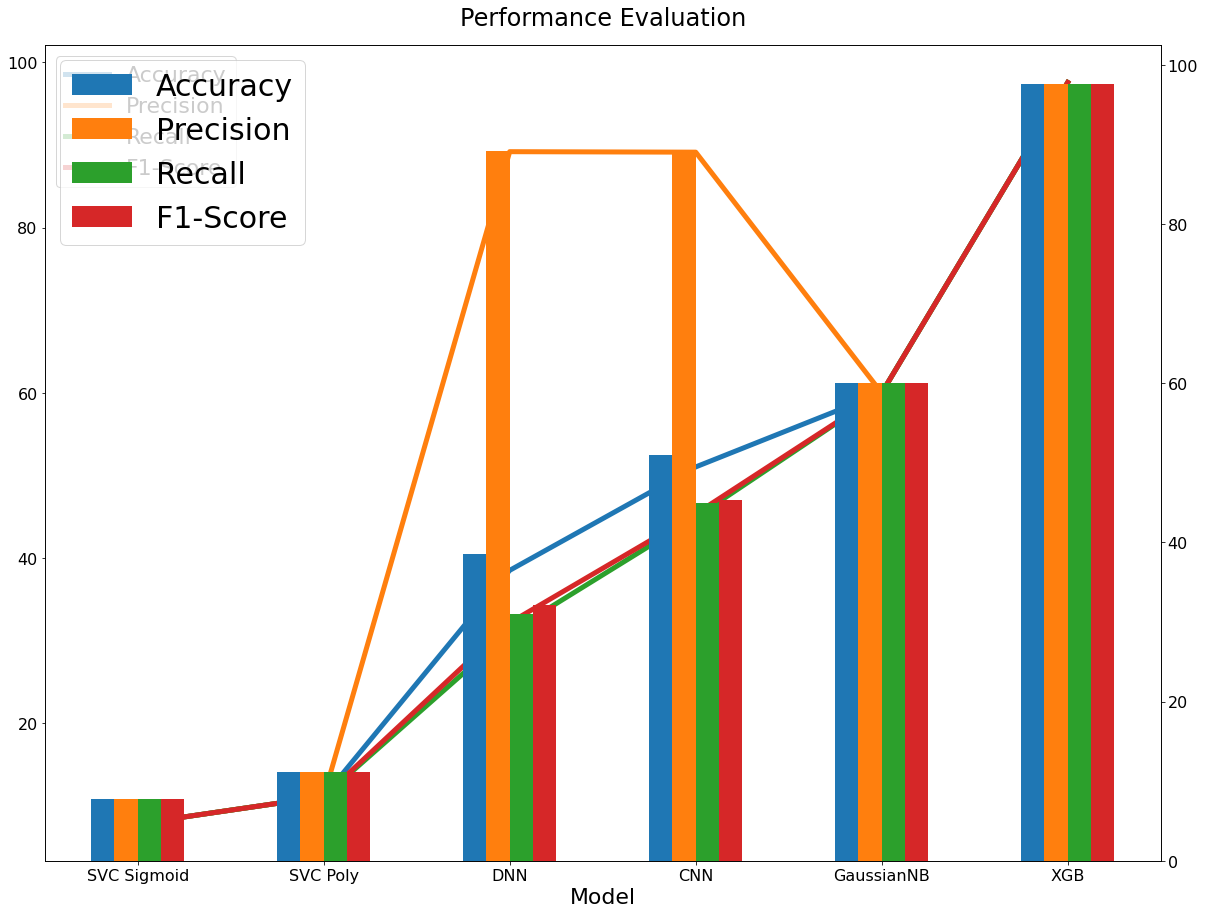

In [154]:
ax1 = df.plot(x='Model',figsize=(20,15),linewidth=5,kind='line',legend=True, fontsize=16)
ax2 = ax1.twinx()
ax3 = df.plot(x='Model',figsize=(20,15),kind='bar',legend=True, ax=ax2, fontsize=16)
ax3.set_title("Performance Evaluation", pad=20, fontdict={'fontsize':24})
ax3.legend(loc=2, fontsize = 30);
#ax3.set_ylabel('',fontdict={'fontsize':24})

Text(0.5, 1.0, 'Performance Evaluation')

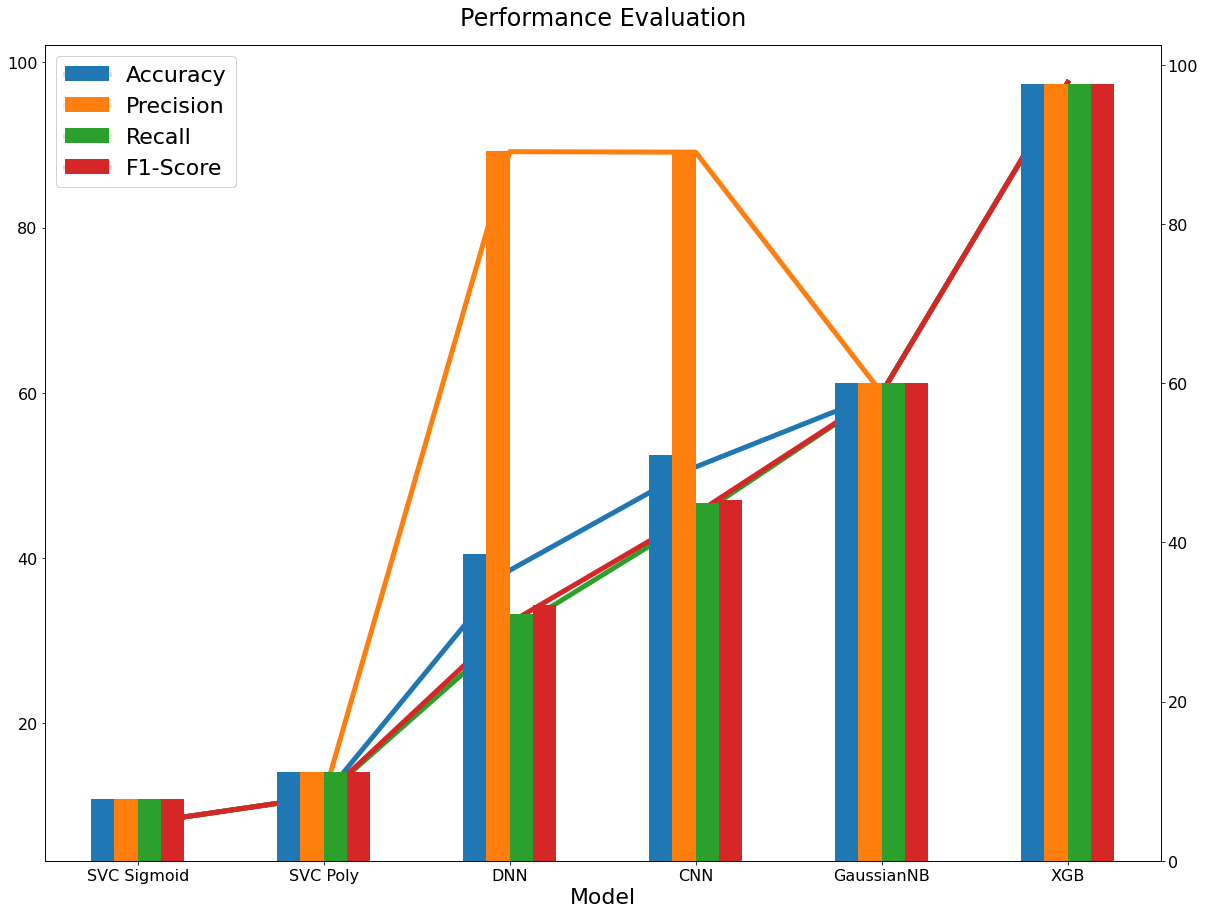

In [156]:
ax1 = df.plot(x='Model',figsize=(20,15),linewidth=5,kind='line',legend=True, fontsize=16)
ax2 = ax1.twinx()
ax3 = df.plot(x='Model',figsize=(20,15),kind='bar',legend=True, ax=ax2, fontsize=16)
ax3.set_title("Performance Evaluation", pad=20, fontdict={'fontsize':24})
#ax3.legend(loc=2, fontsize = 30);
#ax3.set_ylabel('',fontdict={'fontsize':24})